## Settings

In [5]:
import os
from os.path import join as osj
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import numpy as np
import json
from workoutdetector.datasets import RepcountHelper
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.autolayout'] = True
plt.style.use('dark_background')
plt.rcParams['lines.linewidth'] = 0.8
COLORS = list(plt.get_cmap('Set3').colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', COLORS)
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 300
helper = RepcountHelper('../data/RepCount/', '../data/RepCount/annotation.csv') 
info = helper.get_rep_data(['test'], action=['all'])
CLASSES = helper.classes
print(CLASSES)
from workoutdetector.utils.inference_count import pred_to_count, write_to_video
from workoutdetector.utils import plot_all, plot_per_action, plot_pred, plt_params
plt.rcParams.update(plt_params())

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']


## Count

In [6]:
video_save_dir = '../out/acc_0.841_epoch_26_20220711-191616_1x1'
video_json = os.listdir(video_save_dir)
print(video_json[0])
valtest = helper.get_rep_data(['val', 'test'], action=['all']).values()
video_iter = iter(video_json)

stu10_69.mp4.stride_1_step_1.json


In [7]:
json_path = next(video_iter)
js = json.load(open(osj(video_save_dir, json_path)))
gt = np.array(js['ground_truth'])
cls_idx = CLASSES.index(js['action'])
score = js['scores']
score_arr = np.array([list(d.values()) for d in score.values()])
softmax_score_arr = np.exp(score_arr) / np.sum(np.exp(score_arr), axis=1, keepdims=True)
threshold = 0.5
print(js['video_name'], js['action'])
print('count =', len(gt)//2)

stu10_69.mp4 squat
count = 39


In [8]:
print(js['video_name'], js['action'])
print(js['ground_truth'])

stu10_69.mp4 squat
[117, 162, 162, 201, 201, 239, 239, 276, 276, 313, 314, 350, 350, 389, 389, 426, 426, 464, 464, 503, 503, 546, 546, 588, 588, 631, 631, 671, 671, 714, 714, 758, 758, 796, 796, 836, 836, 885, 885, 928, 1221, 1266, 1266, 1304, 1304, 1341, 1341, 1378, 1378, 1416, 1416, 1452, 1452, 1490, 1490, 1527, 1528, 1564, 1564, 1601, 1601, 1635, 1635, 1670, 1670, 1706, 1706, 1742, 1742, 1775, 1775, 1812, 1812, 1847, 1847, 1884, 1884, 1919]


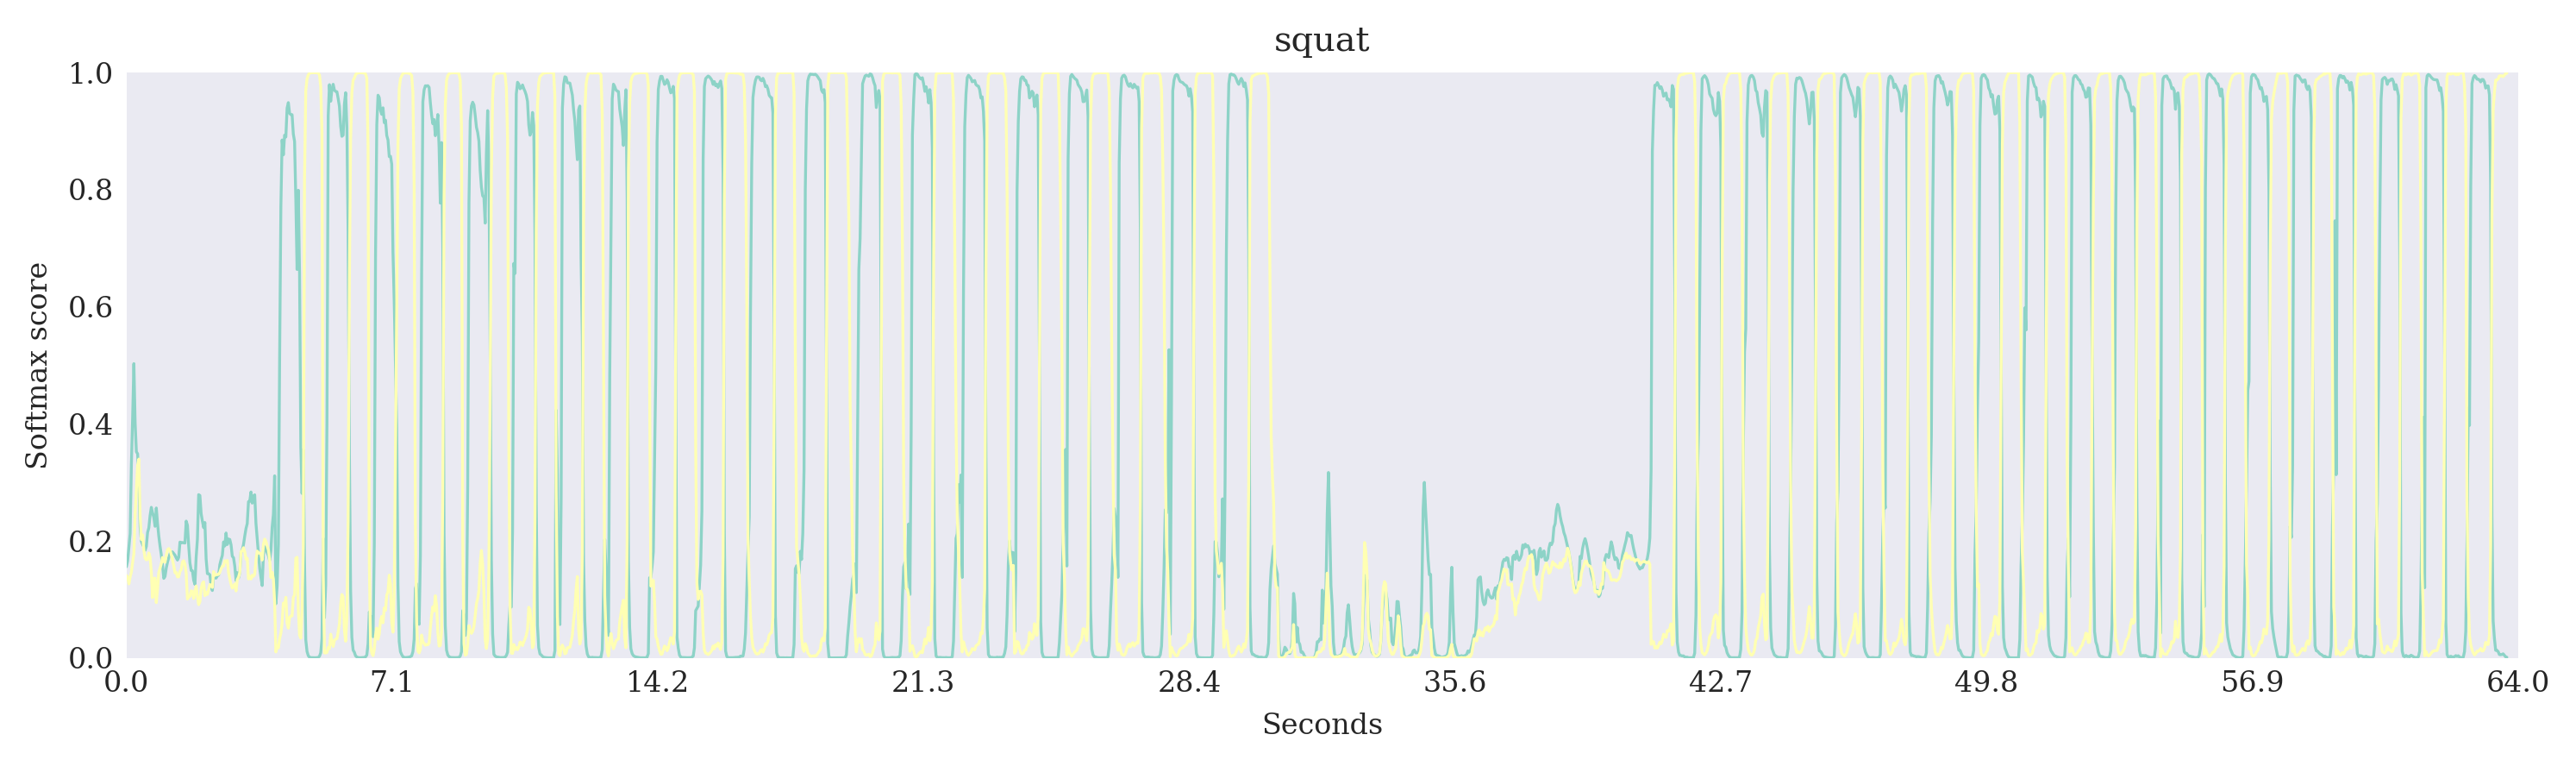

In [9]:
plot_per_action(js, softmax=True, action_only=True)

## Plot predictions

stu3_58.mp4
[16, 48, 64, 88, 104, 128, 144, 160, 184, 200, 216, 240, 256, 280, 304, 320, 336, 368, 376, 408, 416, 448, 456, 488, 496, 528, 656, 680, 696, 720, 736, 760, 824, 840, 864, 880, 904, 920, 936, 960, 976, 1000, 1096, 1112, 1136, 1160, 1176, 1200, 1216, 1240, 1256, 1280, 1344, 1352, 1376, 1400, 1408, 1432, 1448, 1472, 1552, 1560, 1624, 1648, 1664, 1688, 1704, 1728]
gt=42, pred=34
Absolute diff 8


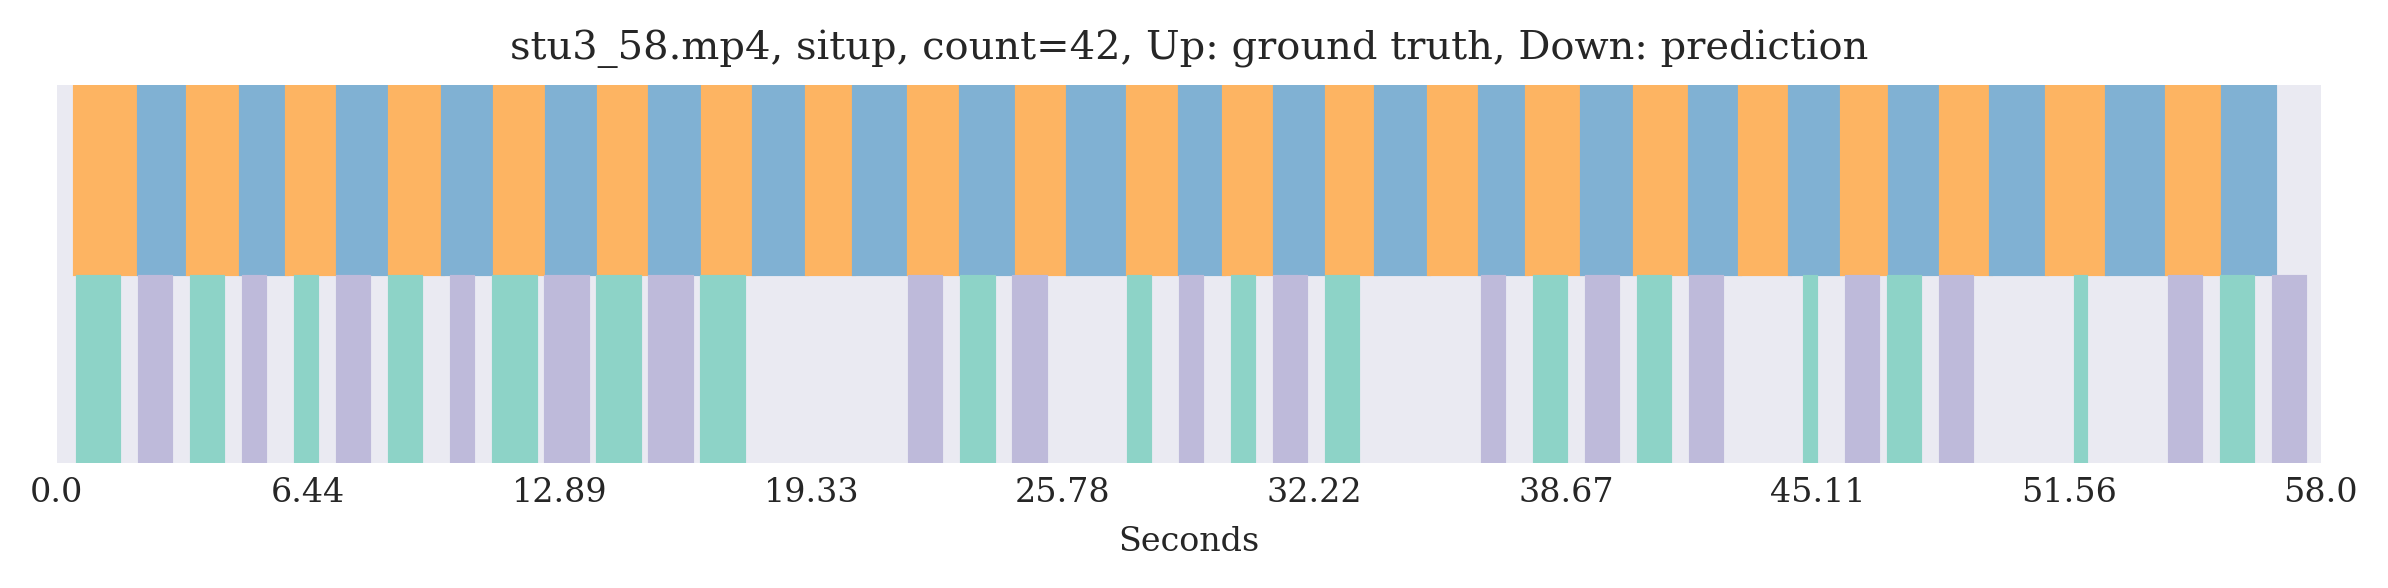

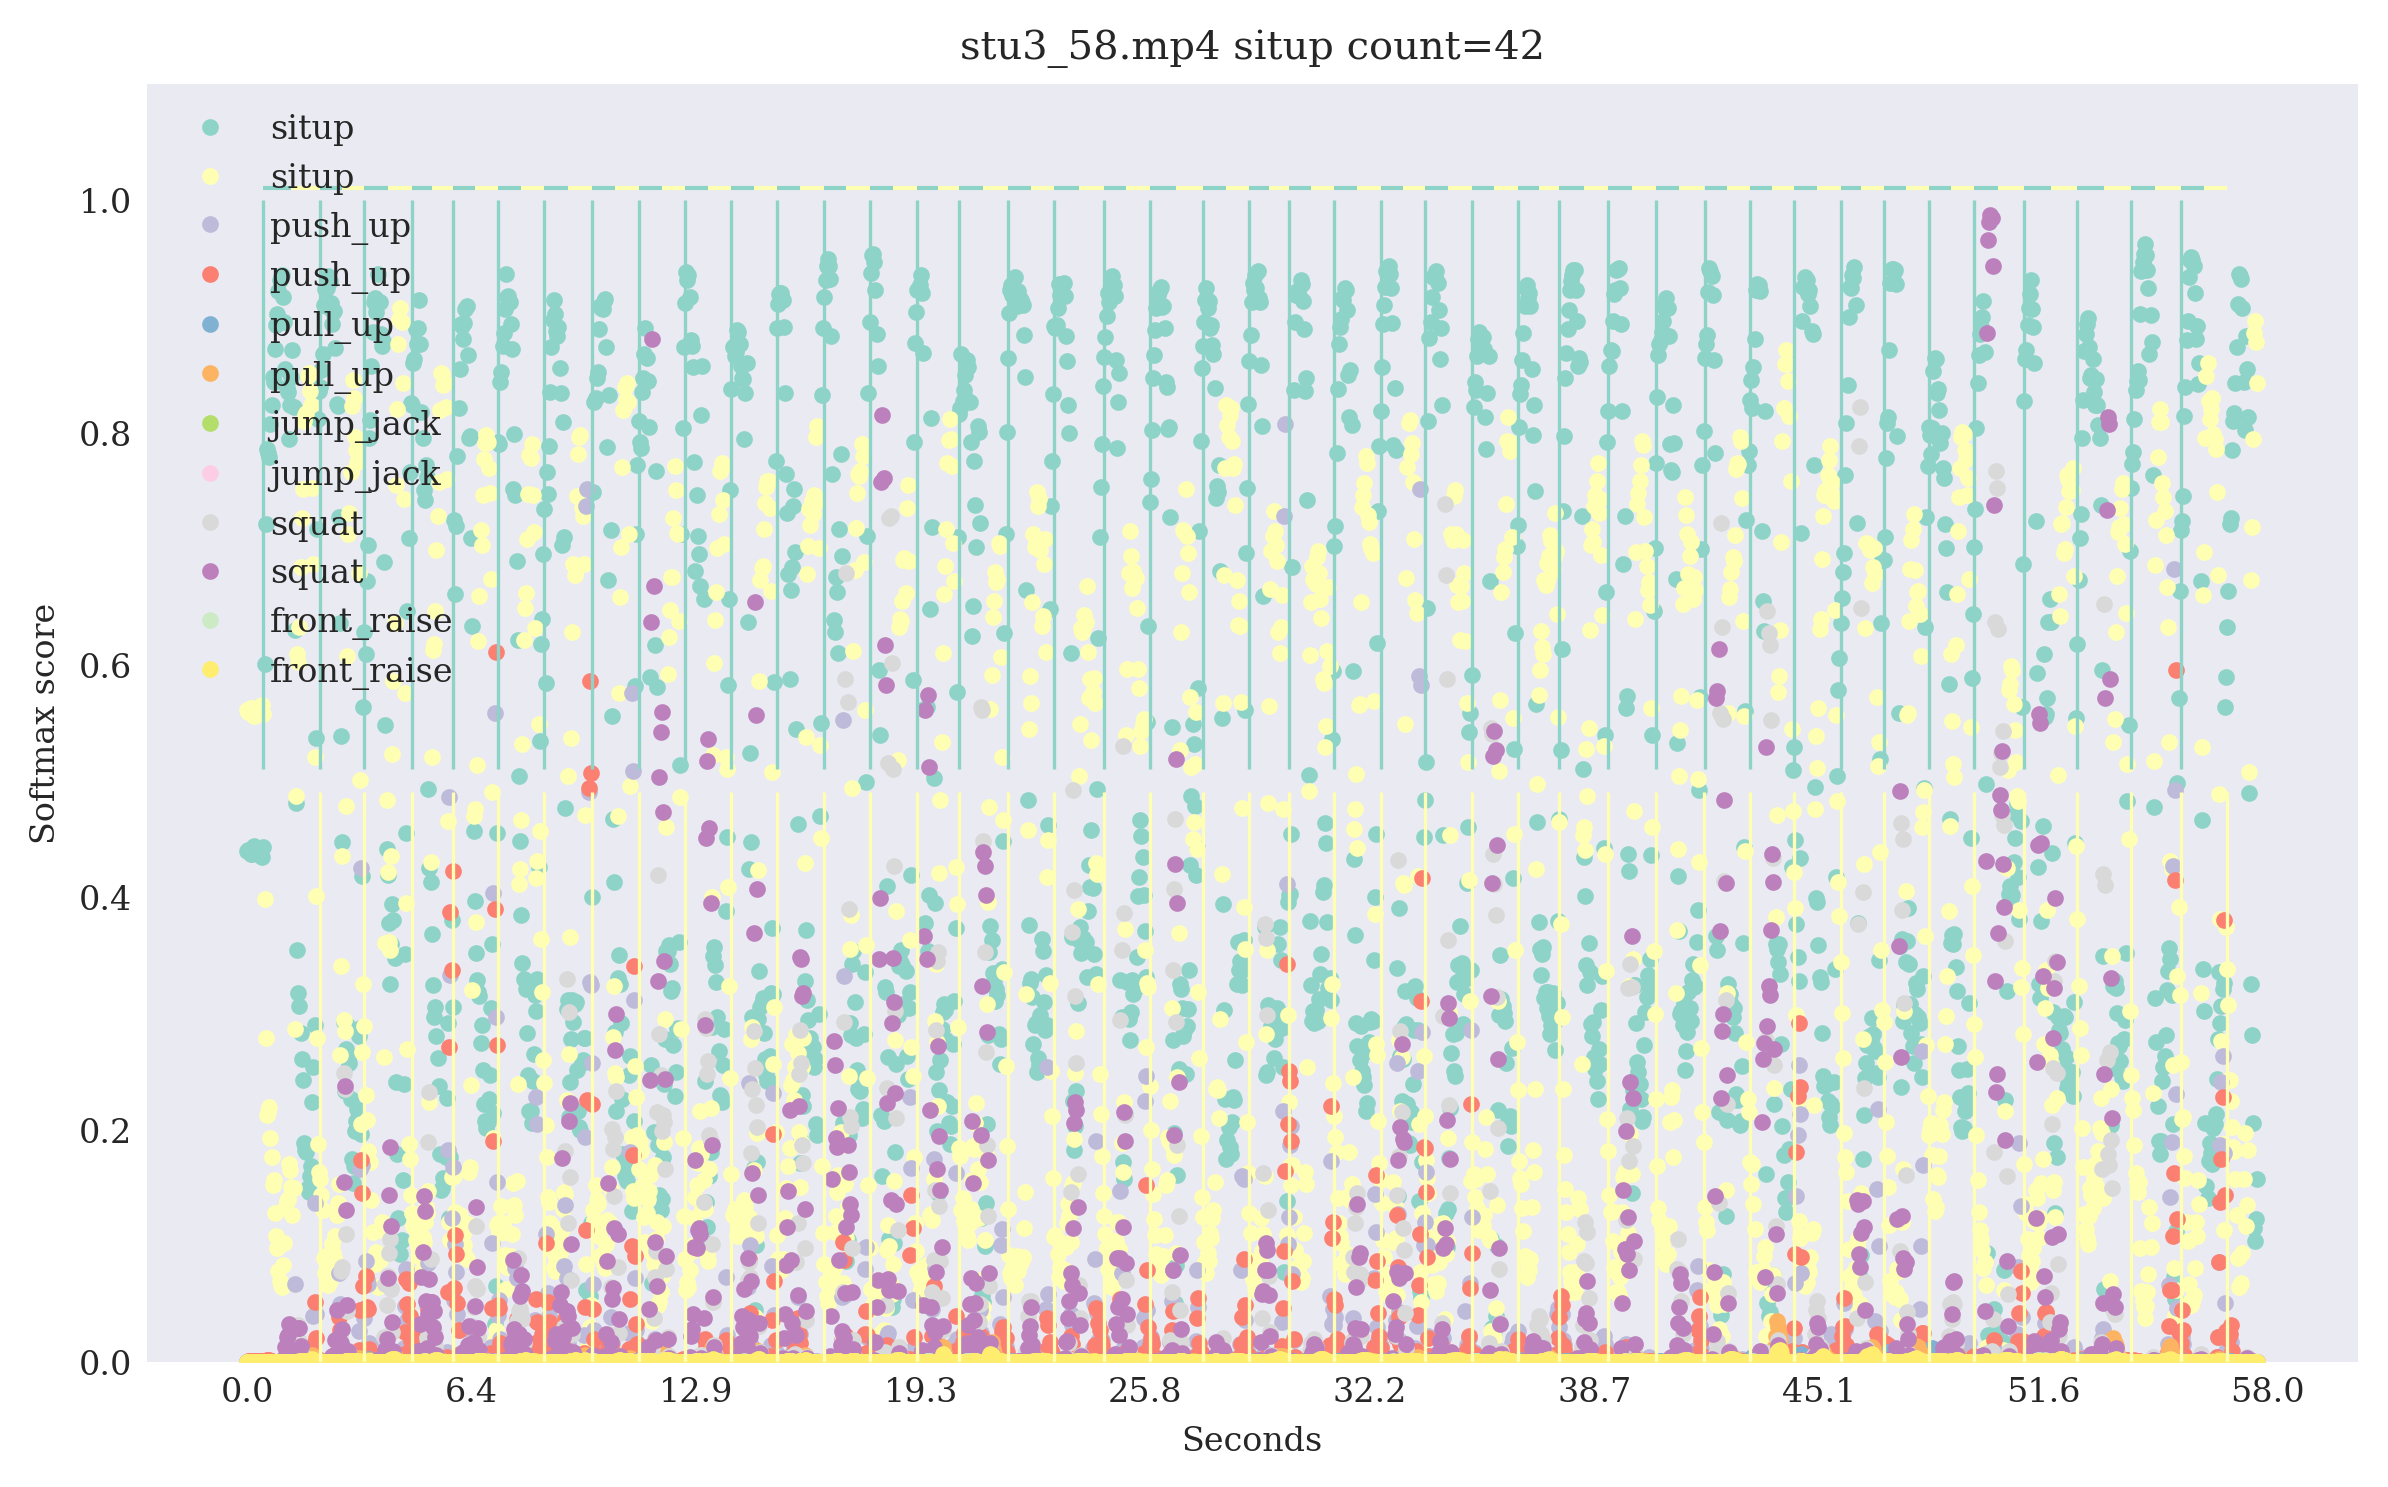

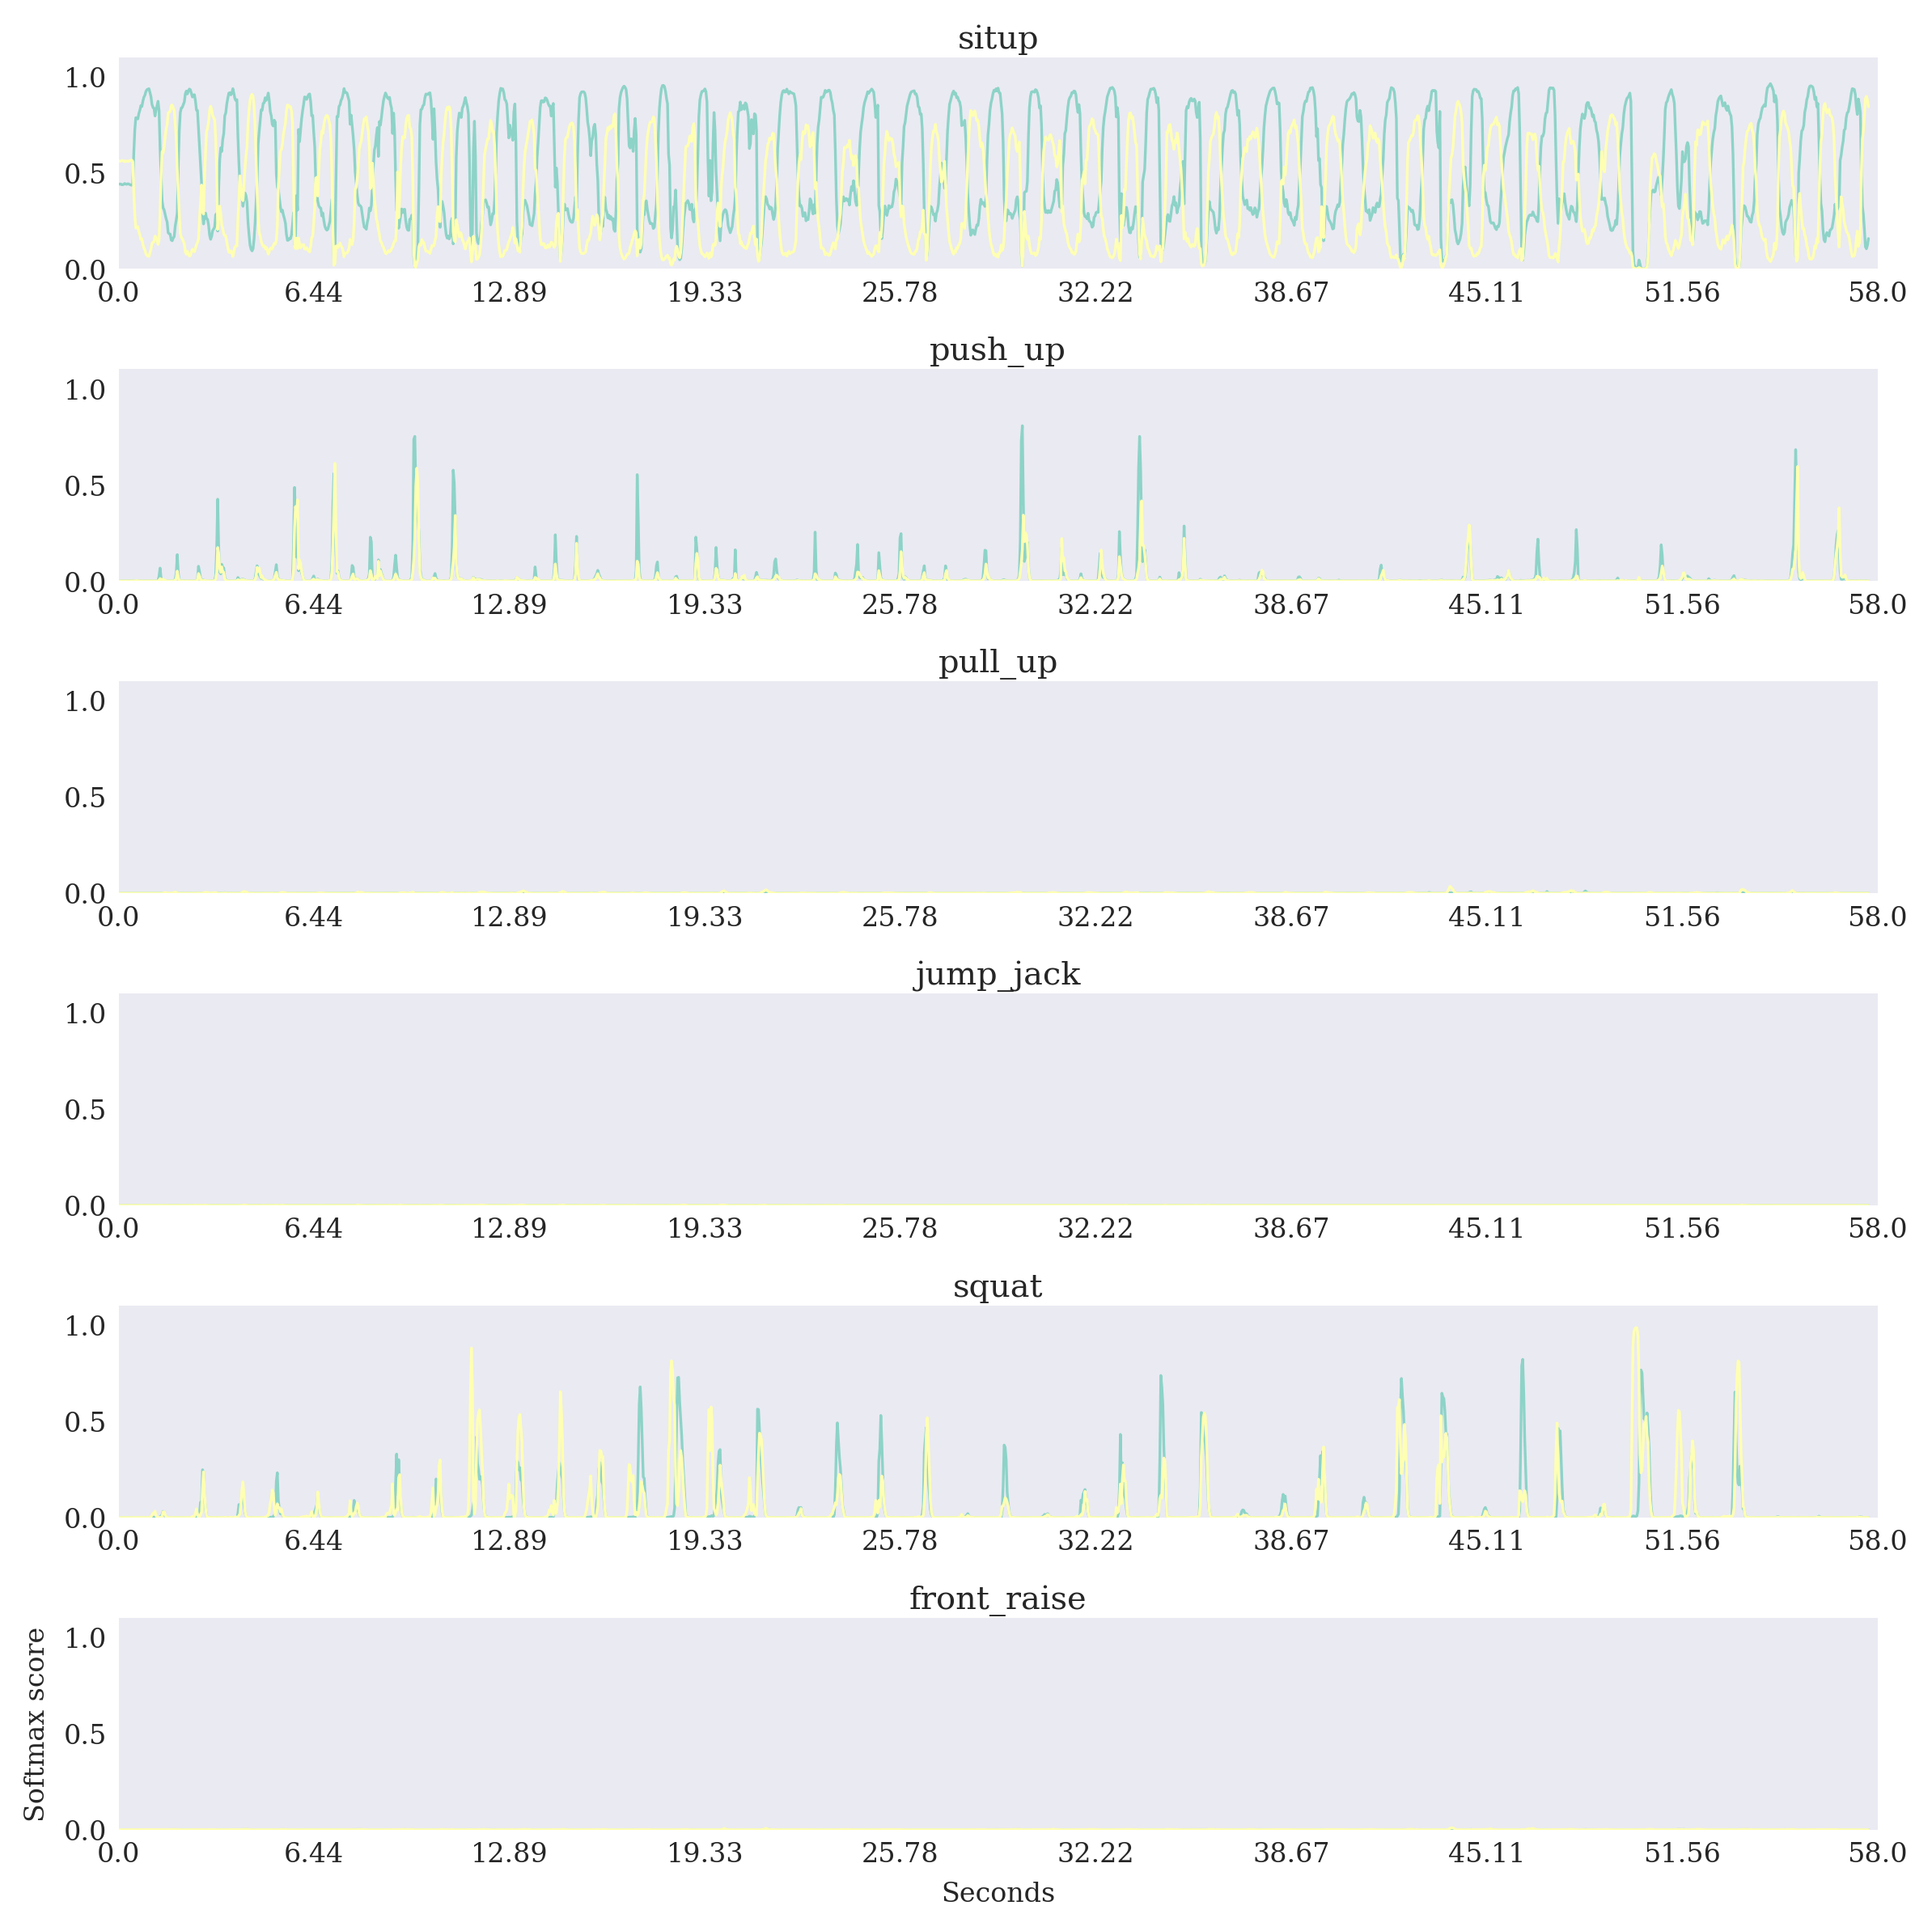

In [47]:
json_path = next(video_iter)
js = json.load(open(osj(video_save_dir, json_path)))
print(js['video_name'])
gt = np.array(js['ground_truth'])
score = js['scores']
threshold = 0.5
# print(score.values())
pred = []

for v in score.values():
    softmax_score = F.softmax(torch.Tensor(list(v.values())), dim=0)
    max_idx = torch.argmax(softmax_score)
    class_id, sc = max_idx.item(), softmax_score[max_idx].item()
    if sc >= threshold:
        pred.append(int(class_id))
    else:
        pred.append(-1)
# print(pred)
result = pred_to_count(pred[::8], stride=8, step=1)
print(result[1])
print(f'gt={len(gt)//2}, pred={result[0]}')
print('Absolute diff', abs(result[0] - len(gt) // 2))

plot_pred(result[1], gt, js['total_frames'], info=js, step=1)
plot_all(gt, info=js, softmax=True, stride=1)
plot_per_action(info=js, softmax=True)

# write_to_video(video_path=os.path.join('/home/user/data/RepCount/videos', x.split, x.video_name),
#                output_path=f'../out/{x.video_name}',
#                reps=result[1],
#                states=pred,
#                step=8)
